In [2]:
#cell 0 member 1
import numpy as np
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
import math
import json
import matplotlib.pyplot as plt
import cv2

In [3]:
#cell 1
def preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Cannot load {img_path}")

    # Contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img)

    # Binarization using Otsu threshold
    th = threshold_otsu(img_clahe)#compute automtically the best threshold
    bw = img_clahe > th #binary image, True(1) is ridges and Flase(0) is the background

    # Skeletonization (invert to make ridges = foreground)
    ske = skeletonize(invert(bw))
    ske_u = img_as_ubyte(ske)  # Convert to 0/255 image
    return img, ske_u

In [4]:
#cell 2
def neighbors_8(img, x, y):
    return [ img[x-1, y], img[x-1, y+1], img[x, y+1], img[x+1, y+1],
             img[x+1, y], img[x+1, y-1], img[x, y-1], img[x-1, y-1] ]

In [5]:
#cell 3
def crossing_number(neigh):
    b = [1 if v>0 else 0 for v in neigh]
    s = 0
    for i in range(8):
        s += abs(b[i] - b[(i+1)%8])
    return s // 2


In [6]:
#cell 4
def extract_minutiae(skel_img, min_dist_edge=10):
    h, w = skel_img.shape
    minutiae = []
    for i in range(1, h-1):
        for j in range(1, w-1):
            if skel_img[i, j] > 0:
                cn = crossing_number(neighbors_8(skel_img, i, j))
                if cn == 1:
                    typ = 'ending'
                elif cn == 3:
                    typ = 'bifurcation'
                else:
                    continue
                if i < min_dist_edge or j < min_dist_edge or i > h - min_dist_edge - 1 or j > w - min_dist_edge - 1:
                    continue
                minutiae.append({'x': int(j), 'y': int(i), 'type': typ})
    return minutiae


In [7]:
#cell 5 member 2
def save_minutiae_json(minutiae, out_path):
    with open(out_path, 'w') as f:
        json.dump(minutiae, f)
    print(f"Saved {len(minutiae)} minutiae to {out_path}")

In [8]:
#cell 6
def visualize_minutiae(orig, skeleton, minutiae, title=None):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(orig, cmap='gray')
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].imshow(skeleton, cmap='gray')
    ax[1].set_title('Skeleton + Minutiae' if not title else title)
    ax[1].axis('off')

    for m in minutiae:
        x, y, t = m['x'], m['y'], m['type']
        if t == 'ending':
            ax[1].plot(x, y, 'ro', markersize=4)
        else:
            ax[1].plot(x, y, 'go', markersize=4)
    plt.show()

In [9]:
#cell 7
def match_minutiae(mins1, mins2, dist_thresh=15):
    used = set()
    matches = 0
    for i, a in enumerate(mins1):
        ax, ay, at = a['x'], a['y'], a['type']
        best_j = None
        best_d = None
        for j, b in enumerate(mins2):
            if j in used: continue
            bx, by, bt = b['x'], b['y'], b['type']
            d = math.hypot(ax - bx, ay - by)
            if best_d is None or d < best_d:
                best_d = d
                best_j = j
        if best_d is not None and best_d <= dist_thresh:
            matches += 1
            used.add(best_j)
    score = matches / max(1, max(len(mins1), len(mins2)))
    return matches, score


fingerprint1.webp.png: extracted 210 minutiae
Saved 210 minutiae to minutiae_fingerprint1.json


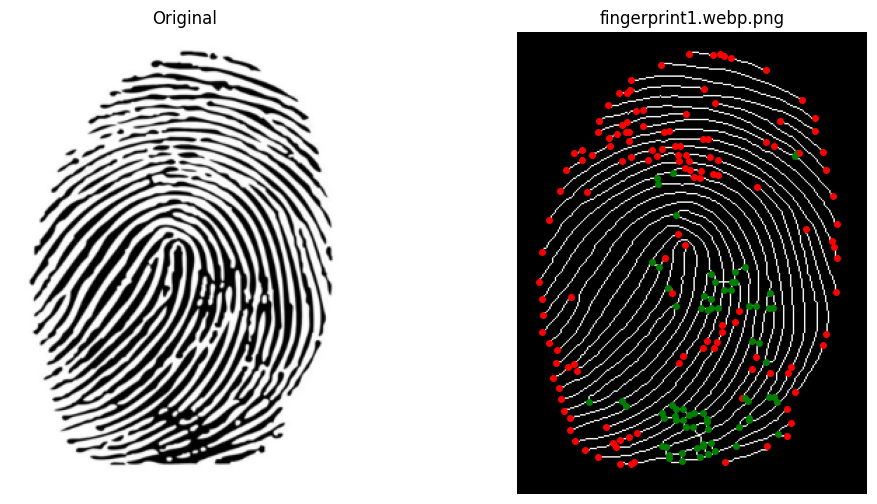

In [10]:
#cell 8 member 3
fp1_name = "fingerprint1.webp.png"
orig1, ske1 = preprocess(fp1_name)
mins1 = extract_minutiae(ske1)
print(f"{fp1_name}: extracted {len(mins1)} minutiae")
save_minutiae_json(mins1, "minutiae_fingerprint1.json")
visualize_minutiae(orig1, ske1, mins1, title=fp1_name)

# positive match

fingerprint2.webp.png: extracted 205 minutiae

--- POSITIVE MATCH TEST RESULTS ---
Comparison: fingerprint1.webp.png vs fingerprint2.webp.png
Matches: 178
Similarity Score: 0.8476


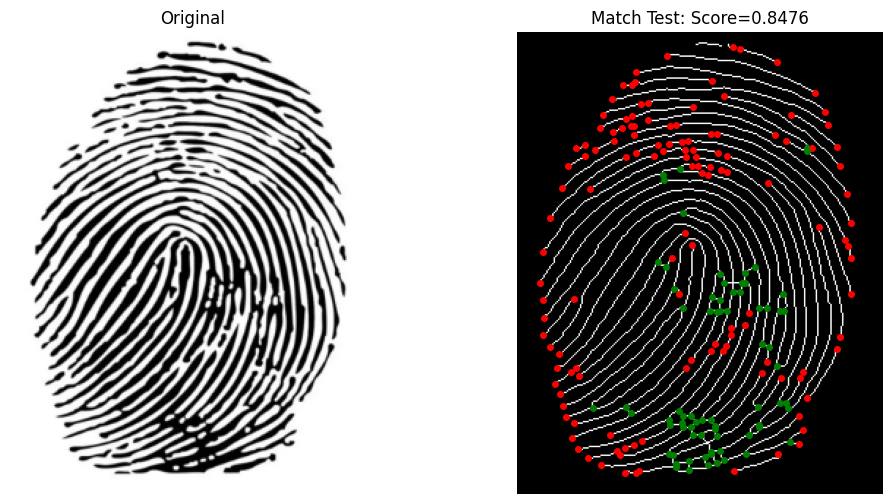

In [11]:
#cell 9
fp2_name = "fingerprint2.webp.png"

orig2, ske2 = preprocess(fp2_name)
mins2 = extract_minutiae(ske2)
print(f"{fp2_name}: extracted {len(mins2)} minutiae")

matches_same, score_same = match_minutiae(mins1, mins2)

print("\n--- POSITIVE MATCH TEST RESULTS ---")
print(f"Comparison: {fp1_name} vs {fp2_name}")
print(f"Matches: {matches_same}")
print(f"Similarity Score: {score_same:.4f}")


visualize_minutiae(orig2, ske2, mins2, title=f"Match Test: Score={score_same:.4f}")

 Negative Match (Different fingerprint)

fingerprint3.jpeg: extracted 294 minutiae

--- NEGATIVE MATCH TEST RESULTS ---
Comparison: fingerprint1.webp.png vs fingerprint3.jpeg
Total Minutiae Matches Found: 31
Similarity Score: 0.1054


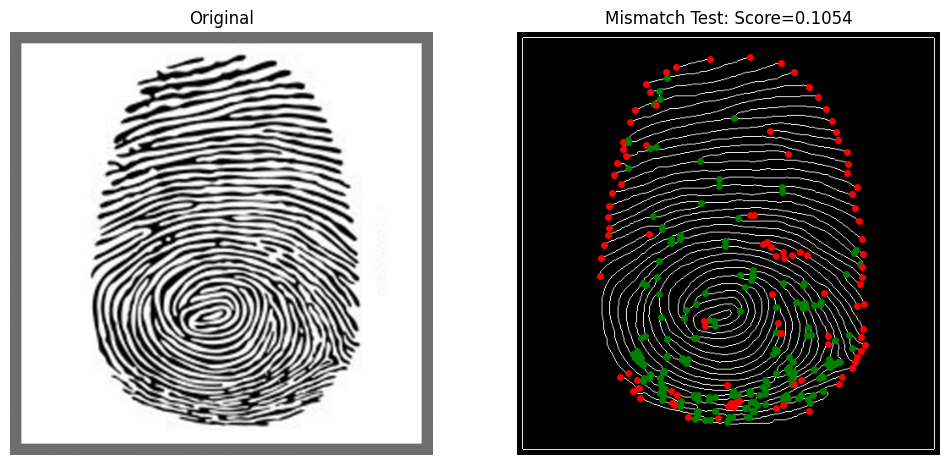

In [12]:
#cell 10
fp3_name = "fingerprint3.jpeg"

orig3, ske3 = preprocess(fp3_name)
mins3 = extract_minutiae(ske3)
print(f"{fp3_name}: extracted {len(mins3)} minutiae")

matches_diff, score_diff = match_minutiae(mins1, mins3)

print("\n--- NEGATIVE MATCH TEST RESULTS ---")
print(f"Comparison: {fp1_name} vs {fp3_name}")
print(f"Total Minutiae Matches Found: {matches_diff}")
print(f"Similarity Score: {score_diff:.4f}")

visualize_minutiae(orig3, ske3, mins3, title=f"Mismatch Test: Score={score_diff:.4f}")

## Part 2 – Fingerprint Matching App (Presentation)

In this section we reuse the functions defined above (`preprocess`, `extract_minutiae`, `match_minutiae`)
to build an interactive fingerprint matching app using Gradio.

Upload two fingerprint images and the app will:
1. Preprocess each fingerprint.
2. Extract minutiae (endings & bifurcations).
3. Match the two minutiae sets.
4. Decide whether they **match** based on a similarity score and threshold.


In [13]:
# Cell 11 — UI helpers (matplotlib -> numpy) and a lightweight overlay renderer (UI-only) member 4
import numpy as np
import matplotlib.pyplot as plt

def fig_to_numpy(fig):
    """
    Render a Matplotlib figure to an RGB numpy array.
    (Non-invasive: UI-only)
    """
    fig.canvas.draw()
    buf = np.asarray(fig.canvas.buffer_rgba())  # (H, W, 4)
    img = buf[:, :, :3].copy()  # drop alpha
    plt.close(fig)
    return img

def build_minutiae_overlay(orig_gray, skeleton_u8, minutiae, title_left="Original", title_right="Skeleton + Minutiae"):
    """
    Build a side-by-side RGB image (numpy) for display.
    This uses your existing data (orig_gray, skeleton_u8, minutiae) and does NOT modify them.
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
    ax[0].imshow(orig_gray, cmap="gray")
    ax[0].set_title(title_left)
    ax[0].axis("off")

    ax[1].imshow(skeleton_u8, cmap="gray")
    ax[1].set_title(title_right)
    ax[1].axis("off")

    # Plot minutiae on the right panel only
    for m in minutiae:
        x, y, t = m["x"], m["y"], m["type"]
        if t == "ending":
            ax[1].plot(x, y, "ro", markersize=4)
        else:
            ax[1].plot(x, y, "go", markersize=4)

    return fig_to_numpy(fig)


In [14]:
# Cell 13 — Simple alignment (centroid + PCA) and alignable matcher wrapper (does NOT change original matcher)
import numpy as np

def align_minutiae_pca(mins):
    """
    Input: list of minutiae dicts [{'x','y','type'}]
    Returns: new list of minutiae dicts rotated so principal axis aligns with x-axis and centered at origin.
    (This only transforms coordinates; types preserved. Does not modify global state.)
    """
    if len(mins) == 0:
        return []
    pts = np.array([[m['x'], m['y']] for m in mins], dtype=float)
    # subtract centroid
    centroid = pts.mean(axis=0)
    pts_centered = pts - centroid
    # PCA via SVD
    U, S, Vt = np.linalg.svd(pts_centered.T, full_matrices=False)
    principal = Vt.T[:, 0]  # principal axis (2,)
    # compute rotation angle to align principal to x-axis
    angle = math.atan2(principal[1], principal[0])
    cosA = math.cos(-angle)
    sinA = math.sin(-angle)
    R = np.array([[cosA, -sinA],[sinA, cosA]])
    pts_rot = pts_centered.dot(R.T)
    # build new minutiae list with rotated + recentred coords (shift back to positive coords)
    pts_rot_shifted = pts_rot - pts_rot.min(axis=0)  # make non-negative for visualization
    new_mins = []
    for (x,y), m in zip(pts_rot_shifted, mins):
        new_mins.append({'x': float(x), 'y': float(y), 'type': m['type']})
    return new_mins

def align_and_match(mins1, mins2, dist_thresh=15):
    """
    Align both sets (translate+rotate using PCA) and run your existing match_minutiae on transformed lists.
    Returns (matches_before, score_before, matches_after, score_after).
    """
    # convert original dict lists to float-preserving copies for before-match display
    try:
        matches_before, score_before = match_minutiae(mins1, mins2, dist_thresh=dist_thresh)
    except TypeError:
        matches_before, score_before = match_minutiae(mins1, mins2)

    aligned1 = align_minutiae_pca(mins1)
    aligned2 = align_minutiae_pca(mins2)

    # match on aligned lists
    try:
        matches_after, score_after = match_minutiae(aligned1, aligned2, dist_thresh=dist_thresh)
    except TypeError:
        matches_after, score_after = match_minutiae(aligned1, aligned2)

    return (matches_before, float(score_before), matches_after, float(score_after))


In [16]:
# Cell 15 — Visualization upgrades: preprocessing panel + improved overlay with legend & counts member 5
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def show_preprocessing_panel(img_path, figsize=(10,10), return_numpy=False):

    # Re-run steps locally (we only call preprocess which returns enhanced gray and skeleton)
    orig_gray, skeleton = preprocess(img_path)  # uses your preprocess (CLAHE + Otsu + skeletonize)
    # Recreate intermediate steps for display: CLAHE image already orig_gray, get binarized
    th = threshold_otsu(orig_gray)
    bw = orig_gray > th

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.ravel()
    axes[0].imshow(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(orig_gray, cmap='gray')
    axes[1].set_title("CLAHE (enhanced)")
    axes[1].axis("off")

    axes[2].imshow(bw, cmap='gray')
    axes[2].set_title(f"Binarized (Otsu th={th:.1f})")
    axes[2].axis("off")

    axes[3].imshow(skeleton, cmap='gray')
    axes[3].set_title("Skeletonized")
    axes[3].axis("off")

    plt.tight_layout()

    plt.show()



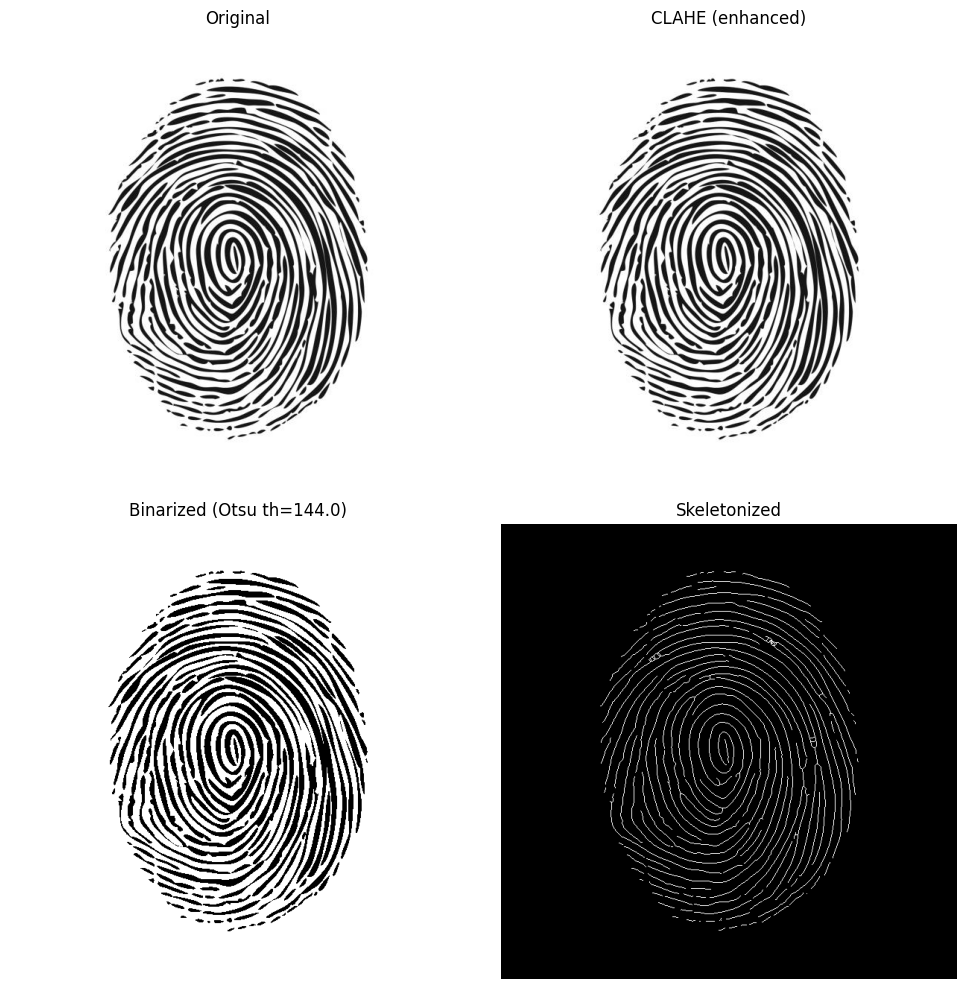

In [17]:
show_preprocessing_panel("fingerprints/f1.jpeg")

In [18]:
# Cell 16 — Threshold analysis & ROC / EER computation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Cell X — compute_scores_for_pairs with optional PCA alignment
import pandas as pd
import numpy as np

def compute_scores_for_pairs(pairs_csv, use_alignment=True, dist_thresh=15):
    """
    Scan CSV (fp1, fp2, label) and compute similarity scores using your pipeline.
    If use_alignment=True: apply align_minutiae_pca() to both minutiae sets BEFORE matching.
    Returns: DataFrame with columns [fp1, fp2, label, score, matches]
    """
    df = pd.read_csv(pairs_csv)
    out_rows = []
    for idx, row in df.iterrows():
        fp1, fp2, label = row['fp1'], row['fp2'], int(row['label'])
        try:
            orig1, ske1 = preprocess(fp1)
            mins1 = extract_minutiae(ske1)

            orig2, ske2 = preprocess(fp2)
            mins2 = extract_minutiae(ske2)

            if use_alignment:
                try:
                    a1 = align_minutiae_pca(mins1)
                    a2 = align_minutiae_pca(mins2)
                except Exception:
                    # if alignment fails for some reason, fallback to original minutiae
                    a1, a2 = mins1, mins2

                # match on aligned lists
                try:
                    matches, sim = match_minutiae(a1, a2, dist_thresh=dist_thresh)
                except TypeError:
                    matches, sim = match_minutiae(a1, a2)
            else:
                # standard path (no alignment)
                try:
                    matches, sim = match_minutiae(mins1, mins2, dist_thresh=dist_thresh)
                except TypeError:
                    matches, sim = match_minutiae(mins1, mins2)

            out_rows.append({
                'fp1': fp1, 'fp2': fp2, 'label': label,
                'score': float(sim), 'matches': int(matches)
            })
        except Exception as e:
            out_rows.append({
                'fp1': fp1, 'fp2': fp2, 'label': label,
                'score': np.nan, 'matches': 0, 'error': str(e)
            })

    out_df = pd.DataFrame(out_rows)
    return out_df

def plot_score_distributions_and_roc(results_df, save_prefix=None):
    """
    Plots genuine vs impostor score histograms and ROC curve; computes EER and suggested threshold.
    Returns eer, suggested_threshold
    """
    df = results_df.dropna(subset=['score'])
    genuine = df[df['label']==1]['score']
    impostor = df[df['label']==0]['score']

    plt.figure(figsize=(8,4))
    plt.hist(genuine, bins=30, alpha=0.7, label='Genuine')
    plt.hist(impostor, bins=30, alpha=0.7, label='Impostor')
    plt.legend()
    plt.title('Score distributions')
    if save_prefix:
        plt.savefig(f"{save_prefix}_dists.png", bbox_inches='tight')
    plt.show()

    # ROC & EER
    fpr, tpr, thresholds = metrics.roc_curve(df['label'], df['score'])
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend()
    if save_prefix:
        plt.savefig(f"{save_prefix}_roc.png", bbox_inches='tight')
    plt.show()

    # Compute EER (point where FNR ~= FPR)
    fnr = 1 - tpr
    abs_diffs = np.abs(fnr - fpr)
    idx_eer = np.argmin(abs_diffs)
    eer = (fpr[idx_eer] + fnr[idx_eer]) / 2.0
    # suggested threshold where FNR ~ FPR
    suggested_threshold = thresholds[idx_eer]

    print(f"EER ≈ {eer:.4f} at threshold ≈ {suggested_threshold:.4f}  (ROC AUC={roc_auc:.4f})")
    return eer, suggested_threshold


In [19]:
# cell 17
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_pairs_and_report(pairs_csv=None, threshold=0.3, out_csv="results_eval.csv", results_df=None, use_alignment=False):
    """
    Improved evaluation wrapper.

    - If results_df is provided, use it directly (preferred).
    - Otherwise, compute scores from pairs_csv with use_alignment flag.
    - Saves detailed results to out_csv and prints confusion matrix + classification report.
    - Returns the DataFrame used for evaluation.
    """
    if results_df is None:
        if pairs_csv is None:
            raise ValueError("Either results_df or pairs_csv must be provided.")
        # compute (will use use_alignment if requested)
        results = compute_scores_for_pairs(pairs_csv, use_alignment=use_alignment)
    else:
        results = results_df.copy()

    # decide using threshold (ignore NaN scores)
    results['pred'] = results['score'].apply(lambda s: 1 if (not pd.isna(s) and s >= threshold) else 0)
    results.to_csv(out_csv, index=False)
    print(f"Saved detailed results to {out_csv}")

    # compute confusion / metrics on valid rows
    valid = results.dropna(subset=['score'])
    if len(valid) == 0:
        print("No valid scores found.")
        return results

    cm = confusion_matrix(valid['label'], valid['pred'])
    print("Confusion matrix (rows: true 0/1, cols: pred 0/1):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(valid['label'], valid['pred'], digits=4))

    # plot confusion matrix heatmap simple
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix (threshold={threshold:.2f})')
    plt.colorbar()
    ticks = [0,1]
    plt.xticks(ticks, ticks)
    plt.yticks(ticks, ticks)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j] > cm.max()/2 else 'black')
    plt.tight_layout()
    plt.show()

    return results


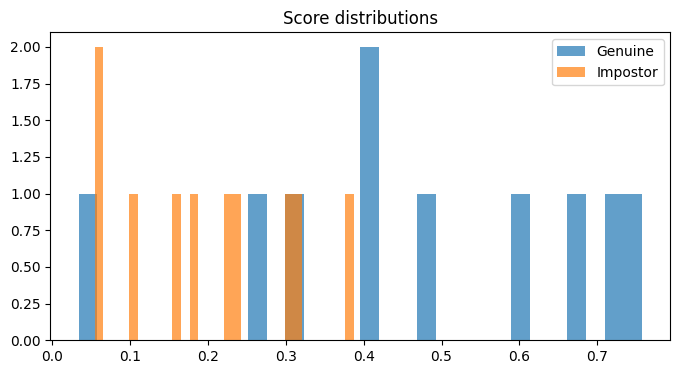

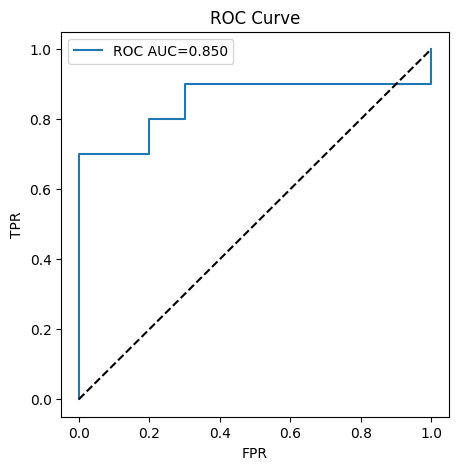

EER ≈ 0.2000 at threshold ≈ 0.3063  (ROC AUC=0.8500)
Saved detailed results to results_eval_aligned.csv
Confusion matrix (rows: true 0/1, cols: pred 0/1):
[[8 2]
 [2 8]]

Classification report:
              precision    recall  f1-score   support

           0     0.8000    0.8000    0.8000        10
           1     0.8000    0.8000    0.8000        10

    accuracy                         0.8000        20
   macro avg     0.8000    0.8000    0.8000        20
weighted avg     0.8000    0.8000    0.8000        20



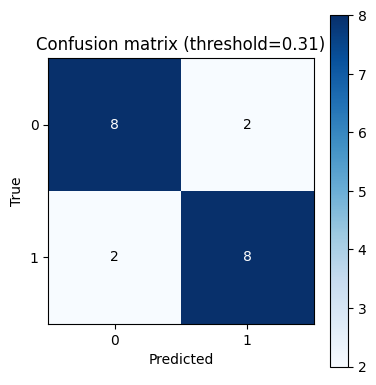

,fp1,fp2,label,score,matches,pred
0,fingerprints/f1.jpeg,fingerprints/f1-copy.jpeg,1,0.720280,206,1
1,fingerprints/f2.png,fingerprints/f2-copy.png,1,0.680952,143,1
2,fingerprints/f3.jpeg,fingerprints/f3-copy.jpeg,1,0.476190,140,1
3,fingerprints/f4.jpg,fingerprints/f4-copy.jpg,1,0.260870,36,0
4,fingerprints/f5.png,fingerprints/f5-copy.png,1,0.757576,50,1
5,fingerprints/f6.png,fingerprints/f6-copy.png,1,0.306306,34,1
6,fingerprints/f7.jpeg,fingerprints/f7-copy.jpeg,1,0.405576,451,1
7,fingerprints/f8.png,fingerprints/f8-copy.png,1,0.590164,36,1
8,fingerprints/f9.png,fingerprints/f9-copy.png,1,0.034483,2,0
9,fingerprints/f10.png,fingerprints/f10-copy.png,1,0.414286,58,1


In [20]:
#cell 18
results = compute_scores_for_pairs("pairs.csv",use_alignment=True)
eer, th = plot_score_distributions_and_roc(results)
evaluate_pairs_and_report(results_df=results, threshold=th, out_csv="results_eval_aligned.csv")


In [24]:

def compare_fingerprints_ui_with_alignment(fp1_path, fp2_path, threshold=0.4, dist_thresh=15, apply_alignment=False):
    if fp1_path is None or fp2_path is None:
        return None, None, "Please upload both fingerprint images.", 0.0

    # --- Fingerprint 1 ---
    orig1, ske1 = preprocess(fp1_path)
    mins1 = extract_minutiae(ske1)

    # --- Fingerprint 2 ---
    orig2, ske2 = preprocess(fp2_path)
    mins2 = extract_minutiae(ske2)

    # --- Optional alignment ---
    if apply_alignment:
        try:
            mins1_use = align_minutiae_pca(mins1)
            mins2_use = align_minutiae_pca(mins2)
            align_tag = " + PCA alignment"
        except Exception:
            mins1_use = mins1
            mins2_use = mins2
            align_tag = " (alignment failed)"
    else:
        mins1_use = mins1
        mins2_use = mins2
        align_tag = ""

    # --- Matching ---
    matches, sim_score = match_minutiae(mins1_use, mins2_use, dist_thresh=dist_thresh)
    sim_score = float(max(0.0, min(1.0, sim_score)))

    decision = "MATCH" if sim_score >= threshold else "NOT MATCH"

    # --- Visualization ---
    img1 = build_minutiae_overlay(orig1, ske1, mins1)
    img2 = build_minutiae_overlay(orig2, ske2, mins2)

    summary = (
        f"### Result: **{decision}**{align_tag}\n\n"
        f"- Similarity score: **{sim_score:.3f}**\n"
        f"- Threshold: **{threshold:.3f}**\n"
        f"- Matched minutiae pairs: **{matches}**\n"
        f"- Minutiae in image 1: **{len(mins1)}**\n"
        f"- Minutiae in image 2: **{len(mins2)}**"
    )

    return img1, img2, summary, sim_score


In [27]:
# ===============================
# FINAL UI — Fingerprint Identification (1-to-N)
# ===============================

import gradio as gr
import os
import numpy as np

# ---- CONFIG ----
FINGERPRINT_DB_DIR = "fingerprints"
EER_THRESHOLD = 0.306   # from your ROC/EER analysis
DIST_THRESH = 15


def identify_fingerprint(fp_path, apply_alignment=True):
    if fp_path is None:
        return None, None, "Please upload a fingerprint image.", 0.0

    # --- preprocess uploaded fingerprint ---
    orig_q, ske_q = preprocess(fp_path)
    mins_q = extract_minutiae(ske_q)

    best_score = -1
    best_matches = 0
    best_file = None
    best_orig = None
    best_ske = None
    best_mins = None

    # --- iterate over database ---
    for fname in os.listdir(FINGERPRINT_DB_DIR):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        db_path = os.path.join(FINGERPRINT_DB_DIR, fname)

        try:
            orig_d, ske_d = preprocess(db_path)
            mins_d = extract_minutiae(ske_d)

            if apply_alignment:
                mins_q_use = align_minutiae_pca(mins_q)
                mins_d_use = align_minutiae_pca(mins_d)
            else:
                mins_q_use = mins_q
                mins_d_use = mins_d

            matches, score = match_minutiae(mins_q_use, mins_d_use, dist_thresh=DIST_THRESH)

            if score > best_score:
                best_score = score
                best_matches = matches
                best_file = fname
                best_orig = orig_d
                best_ske = ske_d
                best_mins = mins_d

        except Exception:
            continue

    # --- decision ---
    decision = "ACCESS GRANTED" if best_score >= EER_THRESHOLD else "ACCESS DENIED"

    # --- visualization ---
    img_query = build_minutiae_overlay(orig_q, ske_q, mins_q)
    img_best = (
        build_minutiae_overlay(best_orig, best_ske, best_mins)
        if best_orig is not None
        else None
    )

    summary = (
        f" {decision}\n\n"
        f"- Best match file: **{best_file if best_file else 'None'}**\n"

    )

    return img_query, img_best, summary, float(best_score)


# -------- UI --------
with gr.Blocks() as demo:
    gr.Markdown("#  Fingerprint Identification System (1-to-N)")
    gr.Markdown(
        "Upload **one fingerprint**. The system will search the database and decide "
        "**ACCESS GRANTED / DENIED** using an EER-based threshold."
    )

    fp = gr.Image(type="filepath", label="Upload Fingerprint")

    apply_alignment = gr.Checkbox(
        label="Apply PCA Alignment",
        value=True
    )

    run_btn = gr.Button("Identify")

    with gr.Row():
        out_q = gr.Image(type="numpy", label="Uploaded Fingerprint")
        out_db = gr.Image(type="numpy", label="Best Database Match")

    out_md = gr.Markdown()
    out_score = gr.Number(label="Best Similarity Score", precision=4)

    run_btn.click(
        fn=identify_fingerprint,
        inputs=[fp, apply_alignment],
        outputs=[out_q, out_db, out_md, out_score]
    )

demo.launch(share=True)


Running on local URL:  http://127.0.0.1:7862

Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB
IMPORTANT: You are using gradio version 3.50.2, however version 4.44.1 is available, please upgrade.
--------

Could not create share link. Missing file: c:\Users\karee\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\frpc_windows_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_windows_amd64.exe
2. Rename the downloaded file to: frpc_windows_amd64_v0.2
3. Move the file to this location: c:\Users\karee\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio
